# Cars Classification on the Stanford dataset (fastai)


First, import fastai vision package and opencv. The fastai library uses Pytorch as a backend.

[link] https://docs.fast.ai/ 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio

## Looking at the data

## Data prprocessing
The aim of the following cell is to extract the train, valid and test folders and organize the training data into Image net folder architecture style, the train/valid split is specified in 'train_split = 0.8' :

/cars_dataset

    /train

        /class 1
    
            .
        
            .
        
            .
        
        /class 196
    
    
    /valid

        /class 1
            .
            
            .
            
            .
        /class 196
   
The test folder contains all the 8041 test images and the labels are provided in 'cars_test_annos_withlabels.mat'


In [ ]:
# This preprocessing portion of the code is provided by foamliu on his github repo
# https://github.com/foamliu/Car-Recognition/blob/master/pre-process.py

import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def save_train_data(fnames, labels, bboxes):
    src_folder ='//home//jupyter//cars_train//'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = '//home//jupyter//.fastai//data//train//'
        else:
            dst_folder = '//home//jupyter//.fastai//data//valid//'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = '//home//jupyter//cars_test//'
    dst_folder = '//home//jupyter//.fastai//data//test//'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('//home//jupyter//devkit//cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('//home//jupyter//devkit//cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


if __name__ == '__main__':
    # parameters
    img_width, img_height = 224, 224

    print('Extracting cars_train.tgz...')
    if not os.path.exists('cars_train'):
        with tarfile.open('//home//jupyter//.fastai//data//cars_train.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting cars_test.tgz...')
    if not os.path.exists('cars_test'):
        with tarfile.open('//home//jupyter//.fastai//data//cars_test.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting car_devkit.tgz...')
    if not os.path.exists('devkit'):
        with tarfile.open('//home//jupyter//.fastai//data//car_devkit.tgz', "r:gz") as tar:
            tar.extractall()

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)
    print('class_names.shape: ' + str(class_names.shape))
    print('Sample class_name: [{}]'.format(class_names[8][0][0]))

    ensure_folder('//home//jupyter//.fastai//data/train')
    ensure_folder('//home//jupyter//.fastai//data/valid')
    ensure_folder('//home//jupyter//.fastai//data/test')

    process_train_data()
    process_test_data()

    # clean up
    shutil.rmtree('cars_train')
    shutil.rmtree('cars_test')
# shutil.rmtree('devkit')

## Prepare data batches
Fastai allows an easy way to create the data batches and apply some augmentation techniques, ImageDataBunch would create ready to use image batches and apply the specified transformations.

In [2]:

data = ImageDataBunch.from_folder('.fastai/data/','train','valid',ds_tfms=get_transforms(do_flip=False, flip_vert=True, max_rotate=5.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),size=224,bs=32).normalize(imagenet_stats)

## A look into a batch 

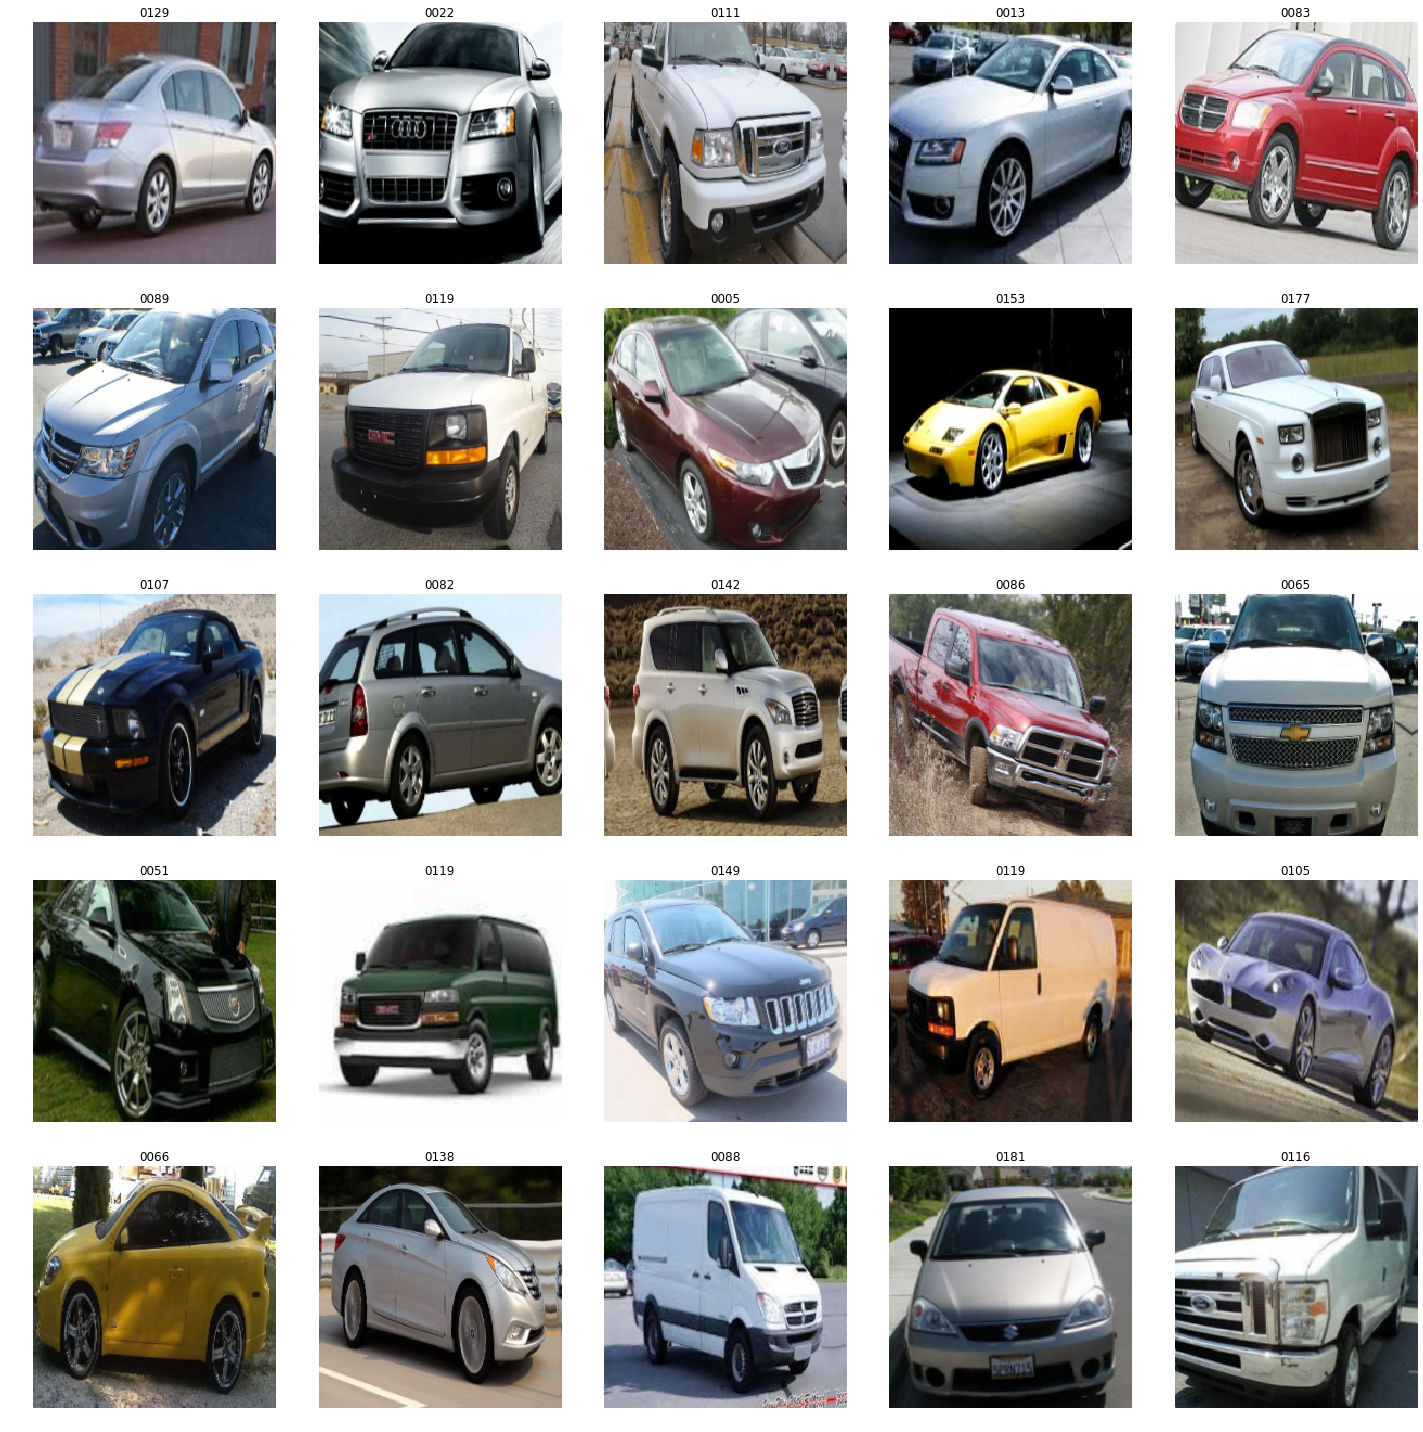

In [3]:
data.show_batch()

In [4]:
# class names and number of classes
print(data.classes)
len(data.classes),data.c


['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125',

(196, 196)

## Training: resne152
For the training, I am using resnet152 and batch size of 32.

In [46]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)

In [6]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,4.128452,3.098078,0.292204,02:28
1,2.306933,1.664139,0.575199,02:27
2,1.327558,1.190102,0.678330,02:27
3,0.846001,1.083771,0.705341,02:28


So, I got around 70% accuracy on the validation set

In [7]:
preds,y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.7053406834602356 %.


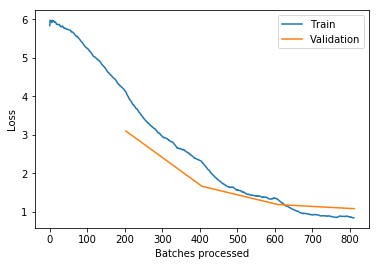

In [8]:
learn.recorder.plot_losses()

Now, let's save the model, we might need it later, 

In [9]:
learn.save('stanford-cars-1')

## Results
In the following cells, let's take a look at the images that the model predicted wrong, We can see that in some cases the model makes wrong predictions between two cars of the same make but not the same model and/or year which is normal since it is very difficult even for a human being to differentiate between them.

e.i. class 0019 'Audi TT Hatchback 2011' and class 0022 'Audi S5 Coupe 2012'

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

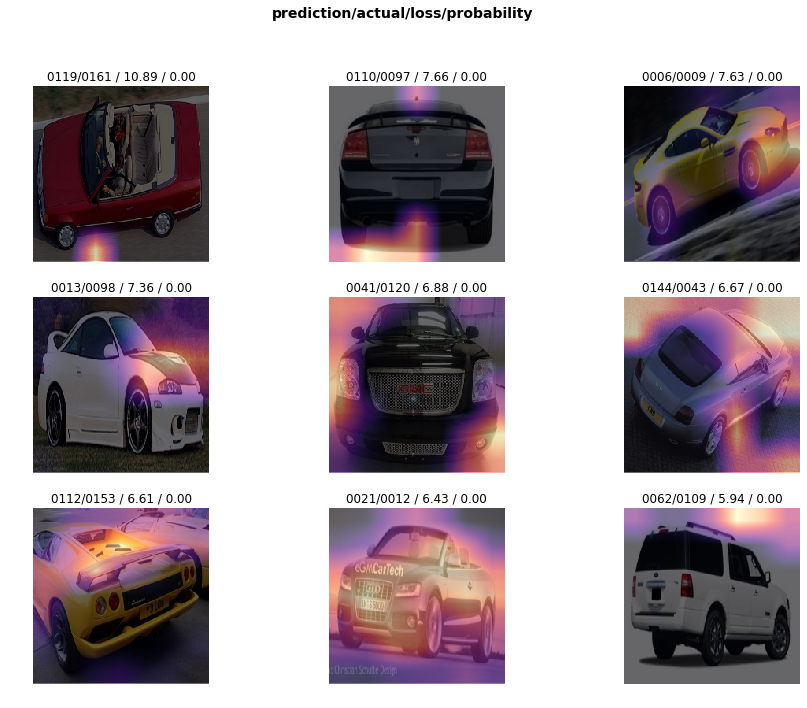

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

## Unfreezing, fine-tuning, and learning rates

Since the model is working as expected, let's  *unfreeze* it and train some more.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


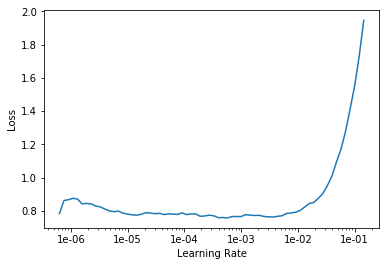

In [13]:
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(14, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.738952,1.033411,0.718846,03:15
1,0.667119,0.937721,0.750767,03:16
2,0.590791,0.810778,0.785758,03:16
3,0.456343,0.711156,0.812769,03:16
4,0.331363,0.642531,0.831185,03:16
5,0.229972,0.588315,0.835482,03:16
6,0.193406,0.550686,0.850215,03:16
7,0.133035,0.527818,0.848987,03:16
8,0.093314,0.505714,0.860651,03:16
9,0.080038,0.478247,0.869245,03:16


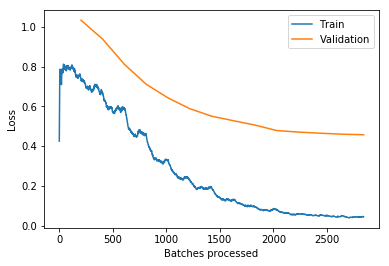

In [15]:
learn.recorder.plot_losses()

Notice the model starts to over-fit, but I can't help with that 
# Predictions on the test set
## Preprocessing the test set 
I have used the labels provided by 'cars_test_annos_withlabels.mat' to create a csv file and used it in the ImageList to prepare the test batches. 

In [16]:
labels = sio.loadmat('//home//jupyter//.fastai//data//cars_test_annos_withlabels.mat')

In [17]:
x = []
for i in range(8041):
    x.append(np.transpose(np.array(labels['annotations']['fname']))[i][0][0])


In [18]:
df=pd.DataFrame(data=np.transpose(np.array(labels['annotations']['class'],dtype=np.int)),
                  index=x)

In [19]:
df.to_csv('//home//jupyter//.fastai//data//test_labels1.csv')

In [20]:

learn.export('/home/jupyter/.fastai/data/export.pkl')
learn = load_learner('/home/jupyter/.fastai/data/', test= ImageList.from_csv('//home//jupyter//.fastai//data//','test_labels.csv',folder='//test'))
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [21]:
a=preds;a.shape

torch.Size([8041, 196])

In [22]:
b=np.array(labels['annotations']['class'],dtype=np.int)-1;b.shape #lbels in range [0..195]
b = torch.from_numpy(b)

In [23]:
acc=accuracy(a,b);acc

tensor(0.8825)

I got 88.25% accuracy on the test set with resnat50 trained on 14 epochs, still there are many things to do to fine tune it. 
I will try them in an other branch.